<a href="https://colab.research.google.com/github/sayan0506/Deep-Learning-for-Drunks-Detection-with-Infrared-Camera/blob/main/Deep_Learning_for_Binary_Drunks_Detection_with_Infrared_Camera.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning for Drunks Detection with Infrared Camera Keras implementation**

The task here is is to build a classifier that can classify for a given image as sober or mild drunk or drunk.  In order to train or test, we can consider all four, front, side etc. at once to classify whether drunk or sober. Detailed problem statement can be found [here](https://docs.google.com/document/d/1cFWjsTds1tODVCGt5Cg-ozIjxOQg3p6jWmyV1RcB4u4/edit)

**Install Dependencies**

In [ ]:
# install wandb
!pip install wandb

# install keras livelossplot
!pip install livelossplot

## **Import Dependencies**

Importing necessary python modules

In [58]:
import os
import logging
import numpy as np
import random
import pandas as pd

from sklearn.model_selection import train_test_split
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib import cm
import cv2
# this is the imshow function which is supported by colab for opencv
from google.colab.patches import cv2_imshow

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from livelossplot import PlotLossesKeras

from sklearn import metrics
from sklearn.metrics import confusion_matrix 

## **Mount Drive**

In [2]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## **Environment Setup**

**Improve Reproducibility**

In [3]:
# improve reproducibility and make it more deterministic
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by removing stochasticity")% 2**32 -1)

**GPU utilization**

In [4]:
# System Setup
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13032943224701148244, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14509932544
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4609447470075800880
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [5]:
# Checking GPU utilization
device = tf.test.gpu_device_name()
if device != '/device:GPU:0':
  raise SystemError('GPU device not found!')

print(f'Found GPU at: {device}')

Found GPU at: /device:GPU:0


**Setup wandb environment for trainining logs**

In [6]:
# import wandb dependencies
import wandb
from wandb.keras import WandbCallback

wandb: WARNING Unable to patch tensorflow.keras for use with W&B.  You will not be able to log images unless you set the generator argument of the callback.


In [7]:
# authorize
wandb.login()

True

## **Dataset Load**

The dataset contains IR images captured from a thermal camera for 50 different people. For each image, the class labels are provided in filenames. The labeling nomenclature is explained along with the data capture process in the “[readme](https://docs.google.com/document/d/1DqlKALYfs9uyE4kB-TXJ8tAN3tKjTu2JL_HXAoga-XY/edit)".

**Shared dataset(accessed through mounted drive) link - [SOBER  -  DRUNK   DATABASE](https://drive.google.com/drive/folders/1P1UG36IzvN0QVntn3t2atph215QU_sG1)**


In [8]:
# dataset path
dataset_path = '/content/drive/MyDrive/DeepLearning_Assignment_Drunk_Sober_Classify'

print('Dataset Content\n')
# explore the content of dataset
os.chdir(dataset_path)
!ls

Dataset Content

 01_petros    12_loukas         23_vassiliskar	 34_alkis
 02_giorgos   13_manos	        24_rig		 35_thanasis
 03_vasil     14_lampros        25_nausika	 36_krod
 04_elpis     15_konstantinos   26_tsag		 37_vassilisA
 05_artemis   16_nikos	        27_theox	 38_christos
 06_tris      17_kwstas         28_frag		 39_anna
 07_thanos    18_dionisis       29_lia		 40_spiliop
 08_tzon      19_pasxalis       30_patty	 41_kalp
 09_giorg     20_nefeli         31_antonis	'Problem Statement.gdoc'
 10_konst     21_ilias	        32_vicky	 readme.gdoc
 11_takis     22_dimitris       33_iliasv	 sample_data_read.ipynb


## **Data Inspection**

Corresponding to each identity 4 different class samples available which corresponds to

1. Sober State
2. Drunk State 1
3. Drunk State 2
4. Drunk State 2

**Classifiers list**

Use only sober state and drunk state for Binary Classification

In [9]:
# available classifiers list in the dataset
available_classifiers_list = ['Sober state', 'Drunk state 1', 'Drunk state 2', 'Drunk state 3']

In [10]:

# classifiers list for binary classification
classifiers_list = ['Sober state', 'Drunk state']

**Defining class dictionaries**

In [11]:
# list of all distionaries dictionaries
class_dict_list = []

# contains person-wise sober sample counts
sober_dict = {}
class_dict_list.append(sober_dict)
# contains person-wise drunk 1 sample counts
drunk1_dict = {}
class_dict_list.append(drunk1_dict)
# contains person-wise drunk 2 sample counts
drunk2_dict = {}
class_dict_list.append(drunk2_dict)
# contains person-wise drunk 3 sample counts
drunk3_dict = {}
class_dict_list.append(drunk3_dict)

**Analyze person-wise drunk samples available count**

In [12]:
# os.walk helps to walkthrough the entire folder one by one starting from base to each individual foler
for i, (_, dirs, files) in enumerate(os.walk(dataset_path)):
  # fetches list of drunk person folders
  drunk_person_list = dirs
  print(f'List of drunk {len(drunk_person_list)} person samples\n{drunk_person_list}\n')
  # counts total samples available class-wise for individual person 

  for identity in drunk_person_list:
    sober_list = []
    drunk1_list = []
    drunk2_list = []
    drunk3_list = []
    # walk through samples of each identity folder
    for sample in os.listdir(identity):
      # finding class index of the sample
      class_idx = int(sample[sample.find(identity)+len(identity)+1]) 
      # if sample for sober state
      if class_idx == 1:
        sober_list.append(sample)
      # if sample for drunk state 1  
      elif class_idx == 2:
        drunk1_list.append(sample)
      # if sample for drunk state 2  
      elif class_idx == 3:
        drunk2_list.append(sample)
      # if sample for drunk state 3  
      elif class_idx == 4:
        drunk3_list.append(sample)
    
    # adding samples to consecuetive class dictionary
    sober_dict[identity] = sober_list
    drunk1_dict[identity] = drunk1_list
    drunk2_dict[identity] = drunk2_list
    drunk3_dict[identity] = drunk3_list
  break

  #a.append(len(files))

List of drunk 41 person samples
['39_anna', '12_loukas', '29_lia', '05_artemis', '41_kalp', '21_ilias', '40_spiliop', '13_manos', '16_nikos', '18_dionisis', '28_frag', '02_giorgos', '06_tris', '01_petros', '24_rig', '14_lampros', '34_alkis', '37_vassilisA', '10_konst', '20_nefeli', '26_tsag', '09_giorg', '03_vasil', '08_tzon', '38_christos', '27_theox', '25_nausika', '17_kwstas', '15_konstantinos', '19_pasxalis', '35_thanasis', '11_takis', '30_patty', '23_vassiliskar', '32_vicky', '04_elpis', '07_thanos', '36_krod', '33_iliasv', '31_antonis', '22_dimitris']



**Visualize the person-wise class distribution**

Total samples available for Sober state - 164

Total samples available for Drunk state 1 - 164

Total samples available for Drunk state 2 - 161

Total samples available for Drunk state 3 - 160



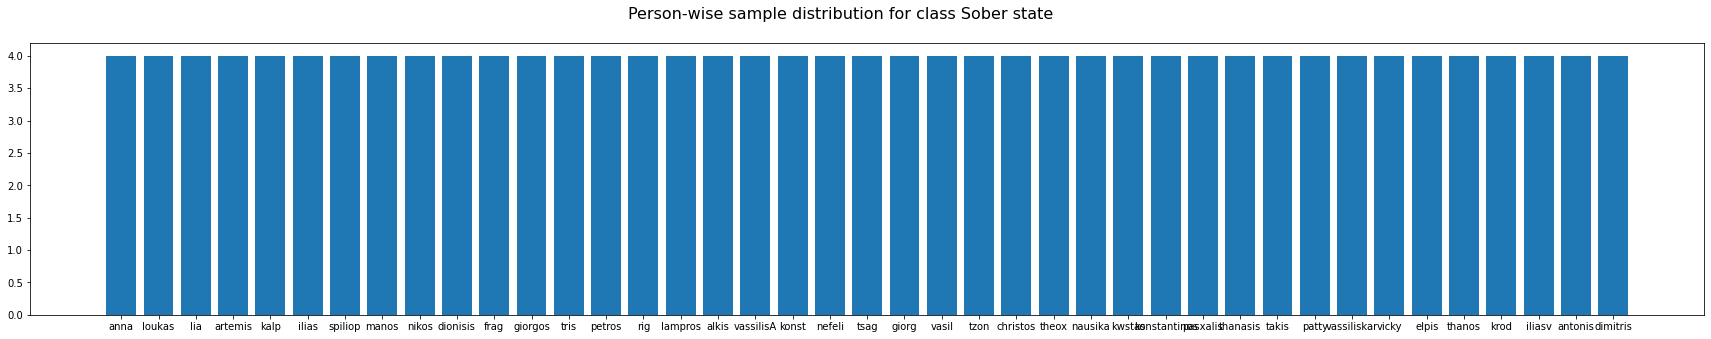

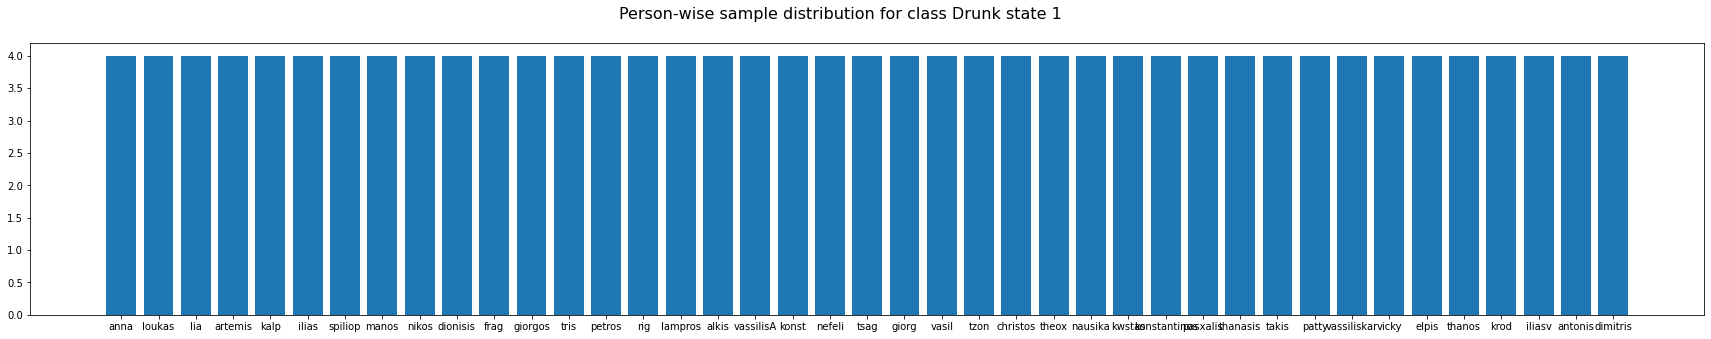

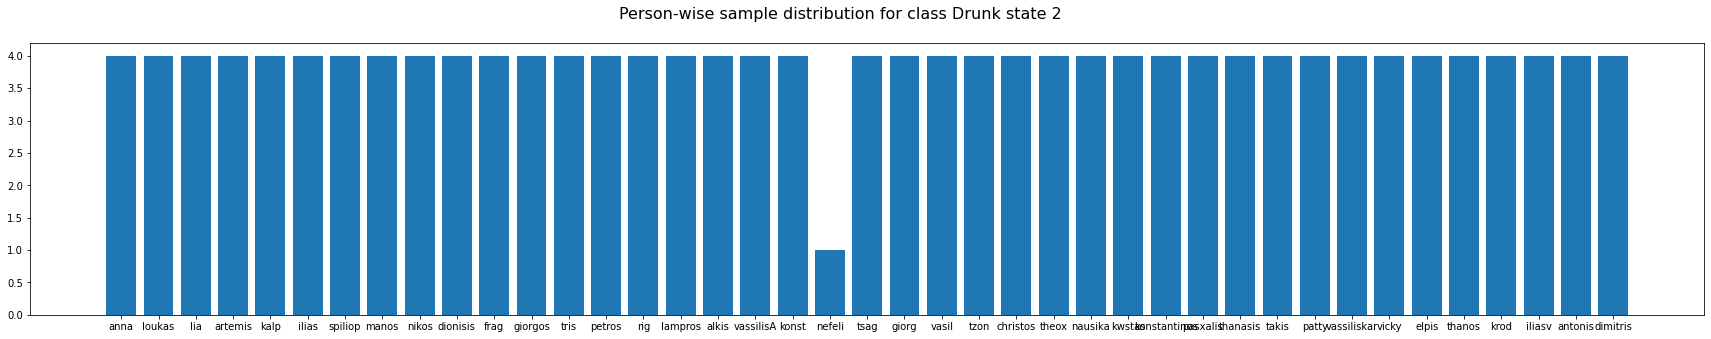

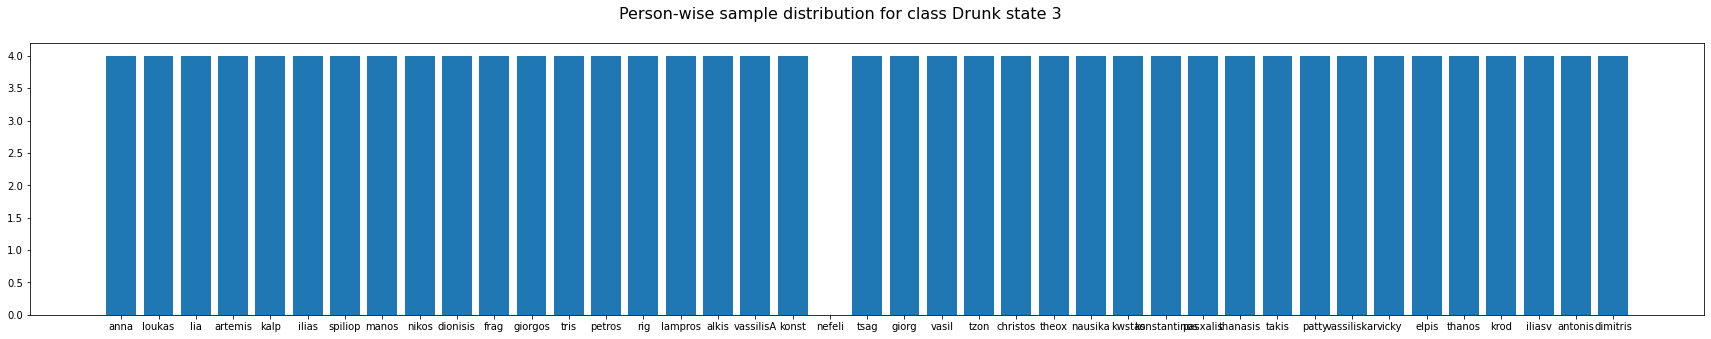

Total 649 image samples are available in the dataset!


In [13]:
# counts total image smple available
sample_total = 0
for i, class_dict in enumerate(class_dict_list):
  # list of identities
  identities = [key[3:] for key in list(class_dict.keys())]
  # list of person-wise sample counts for individual classes 
  samples_count = [len(sample_list) for sample_list in class_dict.values()]
  sample_total += sum(samples_count)
  print(f'Total samples available for {available_classifiers_list[i]} - {sum(samples_count)}\n')  
  # define figure plot
  fig = plt.figure(figsize=(30,5))
  fig.suptitle(f'Person-wise sample distribution for class {available_classifiers_list[i]}', fontsize = 16)
  plt.tight_layout()
  plt.bar(range(len(identities)), samples_count)
  plt.xticks(range(len(identities)), identities)

plt.show()

print(f'Total {sample_total} image samples are available in the dataset!')

From the data analysis it can be found that for **Nefeli**, **Drunk 3** state is not available, and **Drunk 2** state has only 1 sample available.

## **Data Preparation**

#### **Preparing Image Dataframe**

In [14]:
# image dataframe
img_df = pd.DataFrame(columns=['Image', 'Label'])

**Fetching Samples Path in the image dataframe**

In [15]:
# counts total samples
sample_count = 0
for i, class_dict in enumerate(class_dict_list):
  print(f'Loading data for available classifier {available_classifiers_list[i]}...')
  # list of person-wise samples for individual classes and paths 
  for id_path, sample_list in zip(class_dict.keys(), class_dict.values()):
    # defining the identity path
    class_id_path =os.path.join(dataset_path, id_path)
    # fetching images path to image daraframe
    for image in sample_list:
      # note: it's checed that no others files like .dstore in image folders, so no such check is addded here  
      # checks whether '.tif' is available
      if image.endswith(".tif") == True or image.endswith(".TIF") == True:  
        # defines image path
        img_path = os.path.join(class_id_path, image)
        # loading image path, class labels
        # if sober class is there
        if i == 0:
          img_df.loc[sample_count, 'Image'], img_df.loc[sample_count, 'Label'] = img_path, classifiers_list[i] 
        elif i>0:
          img_df.loc[sample_count, 'Image'], img_df.loc[sample_count, 'Label'] = img_path, classifiers_list[1]
        sample_count+=1

# assertion check of image samples fetch
assert sample_total == img_df.shape[0]
print(f'\nCheck passed, {img_df.shape[0]} sample are fetched successfully!\nImage dataframe demo\n')
img_df

Loading data for available classifier Sober state...
Loading data for available classifier Drunk state 1...
Loading data for available classifier Drunk state 2...
Loading data for available classifier Drunk state 3...

Check passed, 649 sample are fetched successfully!
Image dataframe demo



Image        Label
0    /content/drive/MyDrive/DeepLearning_Assignment...  Sober state
1    /content/drive/MyDrive/DeepLearning_Assignment...  Sober state
2    /content/drive/MyDrive/DeepLearning_Assignment...  Sober state
3    /content/drive/MyDrive/DeepLearning_Assignment...  Sober state
4    /content/drive/MyDrive/DeepLearning_Assignment...  Sober state
..                                                 ...          ...
644  /content/drive/MyDrive/DeepLearning_Assignment...  Drunk state
645  /content/drive/MyDrive/DeepLearning_Assignment...  Drunk state
646  /content/drive/MyDrive/DeepLearning_Assignment...  Drunk state
647  /content/drive/MyDrive/DeepLearning_Assignment...  Drunk state
648  /content/drive/MyDrive/DeepLearning_Assignment...  Drunk state

[649 rows x 2 columns]

#### **Train, Validation, Test split**

We are preparing train, valid, test split of the dataframes so that we can implement **stratified train-test split** in the **image_data_generator**.

In [16]:
# train dataframe
train_df = pd.DataFrame(columns=['Image', 'Label'])
# validation main dataframe for valid-test split
valid_main_df = pd.DataFrame(columns=['Image', 'Label'])
# validation dataframe
valid_df = pd.DataFrame(columns=['Image', 'Label'])
# test dataframe
test_df = pd.DataFrame(columns=['Image', 'Label'])

**Defining split ratio and other metadata**

We are taking [train:valid:test] **split ratio** as - **[0.9:0.05:0.05]**

In [17]:
# validation split
val_ratio = 0.10
# test split
test_ratio = 0.5

# fetch only image paths to image ids
img_ids = img_df.loc[:,'Image']

# fetch only labels to label ids
label_ids = img_df.loc[:,'Label']

**Defining Train, Valid, Test split**

Train-Valid_main split

In [18]:
# without shuffling startification is not possible
train_df['Image'], valid_main_df['Image'], train_df['Label'], valid_main_df['Label'] = train_test_split(img_ids, label_ids,
                                                                                                        test_size = val_ratio,
                                                                                                        random_state = 28,
                                                                                                        stratify = label_ids,
                                                                                                        shuffle = True
                                                                                                        )

Valid-Test split

In [19]:
valid_df['Image'], test_df['Image'], valid_df['Label'], test_df['Label'] = train_test_split(valid_main_df['Image'], valid_main_df['Label'],
                                                                                            test_size = test_ratio,
                                                                                            random_state = 28,
                                                                                            stratify = valid_main_df['Label'],
                                                                                            shuffle = True) 

In [20]:
print(f'Train dataframe shape {train_df.shape}')
print(f'Validation dataframe shape {valid_df.shape}')
print(f'Test dataframe shape {test_df.shape}')

Train dataframe shape (584, 2)
Validation dataframe shape (32, 2)
Test dataframe shape (33, 2)


**Startification Check**

Defining visualization function for stratified train test split

In [21]:
# startified vis func
def distribution_vis_check(train, valid, test):
  '''
  Target distribution
  '''
  xdf = [train.index, valid.index, test.index]
  ydf = [train.values, valid.values, test.values]
  label = ['Train Distribution', 'validation Distribution', 'Test Distribution']
  fig = plt.figure(figsize=(20,5))
  for i in range(len(xdf)):
    fig.add_subplot(1, len(xdf), i+1)
    sns.barplot(x = xdf[i], y = ydf[i])
    plt.xlabel(label[i], fontsize = 16)

**Stratification result**

In [36]:
print('Startification result-')
print('Train set -\n{}'.format(train_df['Label'].value_counts()))
print('Validation set -\n{}'.format(valid_df['Label'].value_counts()))
print('Test set -\n{}'.format(test_df['Label'].value_counts()))

Startification result-
Train set -
Drunk state    436
Sober state    148
Name: Label, dtype: int64
Validation set -
Drunk state    24
Sober state     8
Name: Label, dtype: int64
Test set -
Drunk state    25
Sober state     8
Name: Label, dtype: int64


**Startification Distribution Visualize**

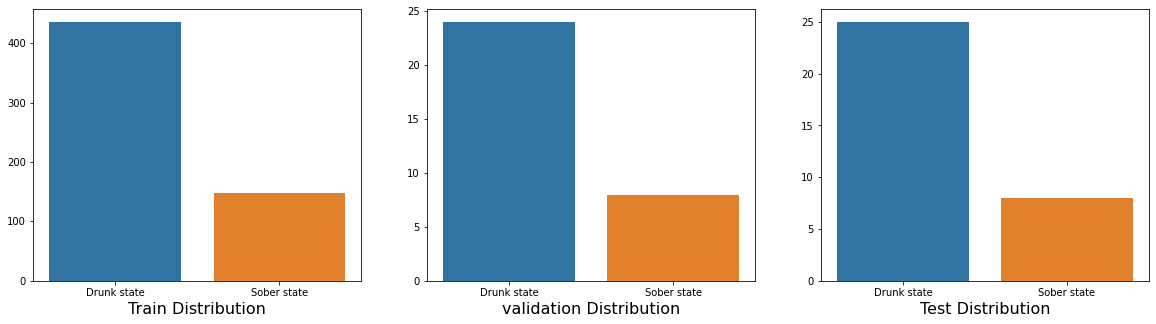

In [37]:
distribution_vis_check(train_df['Label'].value_counts(), valid_df['Label'].value_counts(), test_df['Label'].value_counts())

#### **Define Image Pre-processing function**

It converts the input infrared image to opencv jet colormap and returns as RGB numpy array of datatype float32

In [104]:
def img_preprocess(path):
  # read the infrared image from the given path in unchanged mode
  img = cv2.imread(path, cv2.IMREAD_UNCHANGED)

  # convert from BGR to RGB format
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  
  # convert to float32
  #img = img.astype(np.float32)
  
  # convert to jet colormap by converting to uint8 default format that is acceted by opencv 4.5.2
  img = cv2.applyColorMap((img).astype('uint8'), cv2.COLORMAP_JET)
   
  #img = cv2.normalize(img, None, alpha = 0, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = np.float32)
  # convert to float32
  img = img.astype(np.float32)
  
  # reshape images to (256,256) using keras with 'Bicubic Interpolation
  img = tf.keras.preprocessing.image.smart_resize(img, size=(256,256), interpolation='bicubic')
  
  # normalize the image, as due to interpolation the pixel value may not lie in the range (0,255)
  # to restrict that we neeed to normalize them so than it can lie within a scale 
  img -= img.min()
  img /= (img.max() - img.min()) 

  return img

**Check conversion**

Demo image shape (256, 256, 3)
Demo image datatype float32
Max, min pixel values 0.0, 1.0


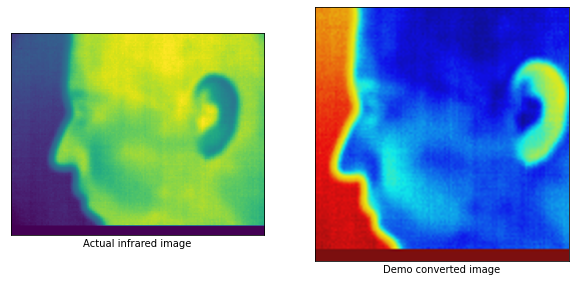

In [111]:
# sample image path
demo_img_path = '/content/drive/MyDrive/DeepLearning_Assignment_Drunk_Sober_Classify/01_petros/01_petros_3_r_M_20_71_032.tif'
demo_img = img_preprocess(demo_img_path)
print(f'Demo image shape {demo_img.shape}')
print(f'Demo image datatype {demo_img.dtype}')
print(f'Max, min pixel values {demo_img.min()}, {demo_img.max()}')
fig = plt.figure(figsize = (10,5))
fig.add_subplot(121)
plt.imshow(cv2.imread(demo_img_path, cv2.IMREAD_UNCHANGED))
plt.xlabel('Actual infrared image')
plt.xticks([])
plt.yticks([])
fig.add_subplot(122)
plt.imshow(demo_img)
plt.xlabel('Demo converted image')
plt.xticks([])
plt.yticks([])

plt.show()

**Visualize sample images of a person**

Demo of single person images named 29_lia
Each of 2nd row is the actual image, and 1st row is the colomap trnsformed image!
Person 29_lia


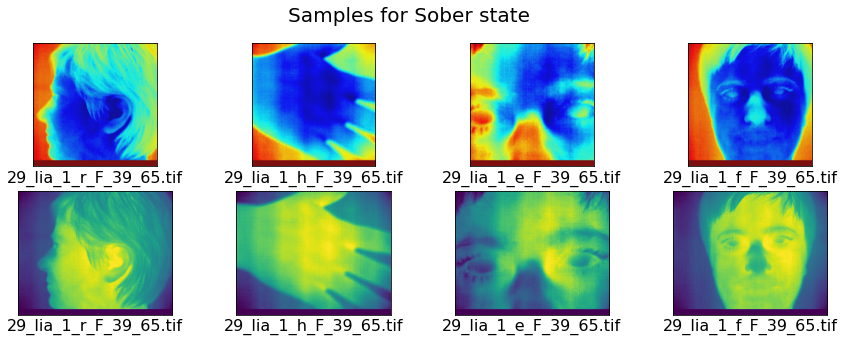

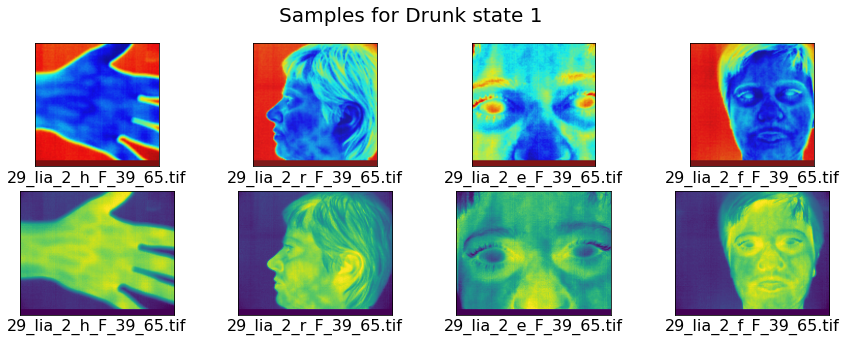

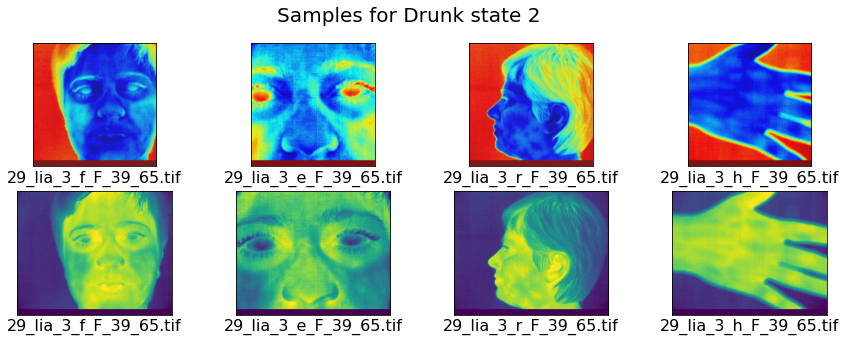

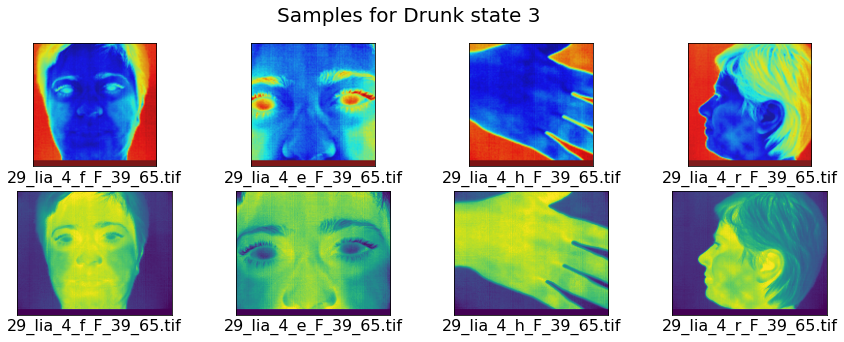

In [40]:
demo_img_path = '/content/drive/MyDrive/DeepLearning_Assignment_Drunk_Sober_Classify/01_petros'
person = list(sober_dict.keys())[2]
print(f'Demo of single person images named {person}')
print('Each of 2nd row is the actual image, and 1st row is the colomap trnsformed image!')
print(f'Person {person}')
for i, dict_ in enumerate(class_dict_list):
  fig = plt.figure(figsize=(15,5))
  fig.suptitle(f'Samples for {available_classifiers_list[i]}', fontsize = 20)
  plt.tight_layout()
  for j, img_sample in enumerate(dict_[person]):
    img_path = os.path.join(dataset_path, person, img_sample)
    demo_img = img_preprocess(img_path)
    fig.add_subplot(2,4,j+1)
    plt.imshow(demo_img)
    plt.xlabel(img_sample, fontsize=16)
    plt.xticks([])
    plt.yticks([])
    fig.add_subplot(2,4,j+1+4)
    plt.imshow(plt.imread(img_path))
    plt.xlabel(img_sample, fontsize=16)
    plt.xticks([])
    plt.yticks([])
    

plt.show()

In [41]:
print(f'Classifiers list {classifiers_list}')

id_list = [i for i in range(len(classifiers_list))]

# labels distionary
label_dict = dict(zip(classifiers_list, id_list))

print(f'Classifiers dictionary\n{label_dict}')

Classifiers list ['Sober state', 'Drunk state']
Classifiers dictionary
{'Sober state': 0, 'Drunk state': 1}


#### **Prepare Train, Valid, Test data and label pair**



In [86]:
# define input, output data prep func.
def dataset_prep(image_df): 
  # input image array list
  x = []
  # output label list
  y = [] 
  for img_path, label in zip(image_df.loc[:,'Image'], image_df.loc[:,'Label']):
    # image conversion
    img = img_preprocess(img_path)
    # image append to list
    x.append(img)
    # label id for sparse categorical crossentropy
    label_id = label_dict[label]
    # append label_id
    y.append(label_id)
  
  # returns input, label list
  return x, y

**Obtain train dataset and label pair**

In [87]:
# train input list
x_train = []
# train output list
y_train = []

# fetch train input, label usinng dataset_prep having attribute is train_df
print('Fetching training data...')
x_train, y_train = dataset_prep(train_df)
assert len(x_train) == len(y_train)
print('Train data prep is done successfully!')

Fetching training data...
Train data prep is done successfully!


**Obtain validation dataset and label pair**

In [88]:
# valid input list
x_valid = []
# valid output list
y_valid = []

# fetch valid input, label usinng dataset_prep hving attribute is valid_df
print('Fetching validation data...')
x_valid, y_valid = dataset_prep(valid_df)
assert len(x_valid) == len(y_valid)
print('Validation data prep is done successfully!')

Fetching validation data...
Validation data prep is done successfully!


**Obtain test dataset and label pair**

In [89]:
# test input list
x_test = []
# train output list
y_test = []

# fetch test input, label usinng dataset_prep hving attribute is test_df
print('Fetching test data...')
x_test, y_test = dataset_prep(valid_df)
assert len(x_test) == len(y_test)
print('Test data prep is done successfully!')

Fetching test data...
Test data prep is done successfully!


#### **Transforming dataset Numpy array**

In [90]:
# train data conversion
x_train, y_train = np.array(x_train), np.array(y_train, dtype=np.int32)
# valid data conversion
x_valid, y_valid = np.array(x_valid), np.array(y_valid, dtype=np.int32)
# test data conversion
x_test, y_test = np.array(x_test), np.array(y_test, dtype=np.int32)

In [91]:
print(f'Train shape, data-type :\n{x_train.shape}, {x_train.dtype}\n{y_train.shape}, {y_train.dtype}')
print(f'Validation shape, data-type :\n{x_valid.shape}, {x_valid.dtype}\n{y_valid.shape}, {y_valid.dtype}')
print(f'Test shape, data-type :\n{x_test.shape}, {x_test.dtype}\n{y_test.shape}, {y_test.dtype}')


# assertion checks
assert x_train.dtype == x_valid.dtype == x_test.dtype == np.float32
assert y_train.dtype == y_valid.dtype == y_test.dtype == np.int32
assert len(x_train.shape) ==  len(x_valid.shape) == len(x_test.shape) == 4

print('All assertion checks are done successfully')

Train shape, data-type :
(584, 256, 256, 3), float32
(584,), int32
Validation shape, data-type :
(32, 256, 256, 3), float32
(32,), int32
Test shape, data-type :
(32, 256, 256, 3), float32
(32,), int32
All assertion checks are done successfully


#### **Image pre-peocessing and data preperation using keras ImageDataGenerator**

* For the flow batch size = 32, shuffle = True, class_mode = Sparse, seed = 1 used.

* Rescaling is not used here, keeping the image as it is
[Reference](https://keras.io/api/preprocessing/image/)

In [113]:
# define batch size based on which datagen will prepare the data
batch_size = 64

In [114]:
# creating imagedatagenerator object using keras
datagen = ImageDataGenerator(rotation_range=None,
                                   width_shift_range = None,
                                   height_shift_range = None,
                                   brightness_range = None,
                                   zoom_range = 0.0,
                                   #rescale = 1./255.,
                                   preprocessing_function = None,
                                   dtype = np.float32,
                                   )

# provide same seed and keyword arguments to the fit and flow methods 
seed = 1

# obtaining images from train dataset and apply augmentation using datagen to create batches
train_generator = datagen.flow(
                              x_train,
                              y=y_train,
                              batch_size=batch_size,
                              shuffle=True,
                              sample_weight=None,
                              seed=seed,
                              save_to_dir=None,
                              save_prefix="",
                              #save_format="png",
                              subset=None,
                          )

# obtaining images from validation dataset and apply augmentation using datagen to create batches
valid_generator = datagen.flow(
                              x_valid,
                              y=y_valid,
                              batch_size=batch_size,
                              shuffle=True,
                              sample_weight=None,
                              seed=seed,
                              save_to_dir=None,
                              save_prefix="",
                              #save_format="png",
                              subset=None,
                          )

# obtaining images from test dataset and apply augmentation using datagen to create batches
test_generator = datagen.flow(
                              x_test,
                              y=y_test,
                              batch_size=batch_size,
                              shuffle=True,
                              sample_weight=None,
                              seed=seed,
                              save_to_dir=None,
                              save_prefix="",
                              #save_format="png",
                              subset=None,
                          )

**Sample images after datagen**

In [115]:
def img_label_samples(train_generator, class_count = 4):
  '''
  Fetches 1st sample of each class from 0 to 61
  Along with the class label or id
  Takes total class samples to be visualized 
  Batch count as attributes
  '''
  # total batches in the train datagenerator
  batch_count = len(train_generator)
  # image list initialization
  img_list = []
  # labels list
  labels = []

  for cls in range(class_count):
    for batch in range(batch_count):
      # traversing through image label or class id
      # O-> Batch, 1-> Class(for 1, 0 for image), 2-> Index of each image in the batch(0 to 31)
      for i, j in enumerate(train_generator[batch][1][:]):
        if int(j)==cls:
          img_list.append(train_generator[batch][0][i])
          labels.append(int(j))
          break
      if int(j) == cls:
        break
  return img_list, labels

Sample image of label 0


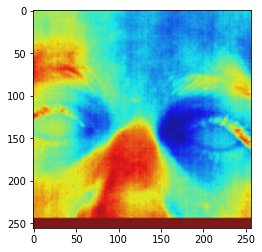

Sample image of label 1


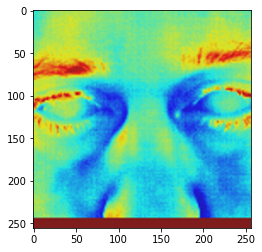

In [116]:
# obtain sample image and label list from train_generator
img_list, labels = img_label_samples(train_generator)

for sample_img, sample_label in zip(img_list, labels):
  print(f'Sample image of label {sample_label}')
  plt.imshow(sample_img, cmap = None)
  plt.show()

**Checking the resize result on the sample images using "Bicubic Interpolation"**

Sample image of label 0


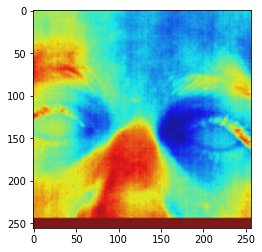

In [117]:
# applying bicubic spline interpolation on the above images
for sample_img, sample_label in zip(img_list, labels):
  print(f'Sample image of label {sample_label}')
  plt.imshow(tf.keras.preprocessing.image.smart_resize(sample_img, size=(256,256), interpolation='bicubic'))
  break

## **CNN Model Building** 

Testing with different pre-trained CNN models using transfer learning and also some custom models training from scratch

In [118]:
# input image shape
input_shape = (256,256,3)

# num of classes
class_num = 1 #for binary classification

**Load the pre-trained model**

1. EfficientNetB2 model

In [119]:
input_tensor = tf.keras.layers.Input(shape = (256,256,3))

# using effifientnetB2 where the image size (260,260,3) 
efficientnet = tf.keras.applications.EfficientNetB2(
    input_tensor = input_tensor,
    include_top = True, # include top is false as we want only 1 class here
    weights = "imagenet"
)

#efficientnet.summary()

#### **Transfer Learning**

In [120]:
x = efficientnet.layers[-2].output
#x = tf.keras.layers.GlobalAveragePooling2D()(x)
#x = tf.keras.layers.Dense(1000, activation='relu')(x)
#x = tf.keras.layers.Dense(512, activation='relu')(x)
#x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(class_num, activation='sigmoid')(x)

model = tf.keras.Model(inputs = efficientnet.input, outputs = x)
#model.summary()

**Define training states of the pretrained model training layers**

In [135]:
# defines whether the layers or which layers will be set for training or freezed
for layer in efficientnet.layers:
  layer.trainable = True

#### **Define a custom base Model**

In [136]:
def base_model(input_shape, num_classes):
  inputs = tf.keras.layers.Input(shape = input_shape)

  x = tf.keras.layers.Conv2D(filters = 16, kernel_size=(3,3), activation='relu', strides=(1,1))(inputs)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides = (2,2))(x)
  x = tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), activation='relu', strides=(1,1))(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides = (2,2))(x)
  x = tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), activation='relu', strides=(1,1))(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides = (2,2))(x)
  x = tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), activation='relu', strides=(1,1))(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides = (2,2))(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(1000, activation='relu')(x)
  x = tf.keras.layers.Dropout(rate = 0.3)(x)
  output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

  return tf.keras.Model(inputs = inputs, outputs = output)

base_model = base_model(input_shape, 1)
base_model.summary()
# save model structure image
#plot_model(base_model, to_file = 'potato_cnn_base.png')

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 30, 30, 32)        0   

#### **Logging the build model to wandb model artifact for model version control**

Model artifact of wandb is being used here for both 
* Initialized model artifact
* Trained model artifact

[Reference](https://github.com/wandb/client)

[Reference notebook](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/wandb-artifacts/Pipeline_Versioning_with_W&B_Artifacts.ipynb#scrollTo=XZ3dp-1jCbEG)

**Define model artifact metadata**

In [137]:
# artifact id as projet name
model_artifact_id = "Drunk_detection_from_infrared_image"
# artifact name
model_artifact_name = "drunk_convnet"

# config dict for model
model_config = {"num_classes": class_num,
                "input_shape": input_shape
}

# define which model to log whether transfer learning one or custom
logged_model = model
#logged_model = base_model

**Initialize and log the inititalized model to model artifact**

Change the cwd to '/content/'

In [138]:
%cd /content/

/content


In [139]:
try:
  # initialize wandb artifact project with default name for CNN model
  with wandb.init(project= model_artifact_id, job_type = "initialize", config = model_config) as run:
    
    # config the wandb config attribute 
    config = wandb.config
    
    # define artifact for drunk detection model
    model_artifact = wandb.Artifact(
        model_artifact_name, type = "model",
        description = "drunk_cnn_model",
        metadata = dict(config)
    )
    
    
    initialized_model_file = "initialized_drunk_model.keras"
    # save the initialized model
    logged_model.save(initialized_model_file)
    # add model file to model artifact
    model_artifact.add_file(initialized_model_file)
    # save the initialized model to that file
    wandb.save(initialized_model_file)

    # log the artifact to wandb
    run.log_artifact(model_artifact)
    
except Exception as e:
  logging.exception("message")

wandb: Wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## **Configure Model Training**

#### **Define Training metadata**

In [140]:
# learning rate
learning_rate = 0.001 # initial lr

# epochs no.
epochs = 30

# loss function
loss_fn = tf.keras.losses.BinaryCrossentropy()

# optimizer
optim = tf.keras.optimizers.Adam(learning_rate = learning_rate)

# define class_weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)

# weights dict
class_ids = [i for i in range(len(class_weights))]

weight_dict = dict(zip(class_ids, class_weights))
print(f'Class weights\n{weight_dict}')

Class weights
{0: 1.972972972972973, 1: 0.6697247706422018}


**Define training metrics**

Define true-positive, false-positive, true-negative, false-negative, precision, recall, area under curve for precision-recall curve

In [141]:
metrics = [
           tf.keras.metrics.TruePositives(name='tp'),
           tf.keras.metrics.FalsePositives(name='fp'),
           tf.keras.metrics.TrueNegatives(name='tn'),
           tf.keras.metrics.FalseNegatives(name='fn'),
           tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc'),
           tf.keras.metrics.AUC(name='prc', curve='PR') # precision-recall curve
]

#### **Define Training steps for train and log to wandb**

**Training artifact metadata**

In [142]:
# train artifact name
train_arrtifact_name = "drunk_detection_training"

# configure callbacks
callback_config = {"log_weights": True, # ensured weights will be logged to wandb
                   "save_model": True,
                   "log_batch_frequency": 10, # log training after 10 batch
                   "verbose": 1
}

# define train config
train_config = {"batch_size": batch_size,
                "epochs": epochs,
                "optimizer": optim,
                "callback_config": callback_config
}

print('Training configuration')
train_config

Training configuration


{'batch_size': 64,
 'callback_config': {'log_batch_frequency': 10,
  'log_weights': True,
  'save_model': True,
  'verbose': 1},
 'epochs': 30,
 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam at 0x7f21f4f15bd0>}

#### **Define Callbacks**

In [143]:
# initially erro is too high so starting from LR 1e-01 as the initial LR
# learning rate scheduler to obtain optimum LR
# schedule is exponential decaying LR
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-03/(epoch+1))

# if it observes val_acc is stuck in a plateu, reduces learning_rate by factor 0.2 with patience = 5
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_acc',
                                                 factor = 0.2,
                                                 patience = 5) 
# define wandb callback
wandb_callback = WandbCallback(verbose = 1, save_model=True, log_weights=True)
                               #,validation_data=(x_valid, y_valid))

# callbacks list
# plotlosseskeras helps to plot realtime the training metrics
callbacks = [wandb_callback, reduce_lr, PlotLossesKeras()]

**Load initialized model from model artifact**

In [144]:
def download_inititalized_model(model_artifact_id, train_config, initialized_model_file):
    model_initialized_filename = initialized_model_file
    '''
    Defining training and log steps to wandb
    '''
    try:
      # add train config while initializing the train with block
      with wandb.init(project = model_artifact_id, job_type = "train", config = train_config) as run:
        config = wandb.config
        
        # use the latest model artifact used previously
        #Note: Always use that syntax never use space, wrong: ("potato_convnet: latest"), correct: ("potato_convnet:latest")  
        
        model_artifact = run.use_artifact(model_artifact_name+":latest")
        print(f'Using the artifact - {model_artifact_name+":latest"}')
        # download latest version of the model artifact
        model_dir = model_artifact.download()
        # load the downloaded model(initialized) of model artifact from model_dir
        model_path = os.path.join(model_dir, model_initialized_filename)
        # load the model from model path using keras for training
        model = tf.keras.models.load_model(model_path)
        
        # load model metadata to model_config
        model_config = model_artifact.metadata
        
        # update the config with that model config
        config.update(model_config)

      return model

    except Exception as e:
      logging.exception("message")


In [145]:
# download the initialized model
load_model = download_inititalized_model(model_artifact_id, train_config, initialized_model_file)

wandb: Wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Using the artifact - drunk_convnet:latest


#### **Model Compile**

In [148]:
# compile the model
load_model.compile(optimizer=optim,
                   loss = loss_fn,
                   metrics=metrics
)

print('Done compiling!')

Done compiling!


#### **Define train fn**

In [1]:
def train(model, training, validation, callbacks, config, weight_dict = None):
  '''
  defining model training steps
  '''
  try:      
    print('STarting training....')
    # defining model fit 
    # passing train datagenerator, validation data generator
    history = model.fit(training, validation_data = validation, 
              # batch_size = config.batch_size, # batch size is mentioned while building data generator
              epochs = config.epochs,
              callbacks = callbacks,
              verbose = 1,
              class_weight = weight_dict #pass class weight dictionary
    )

    return history

  except Exception as e:
    logging.exception('message')

In [ ]:
class_weights

array([1.97297297, 0.66972477])

In [ ]:
weight_dict = {0: 1.97297297, 1:0.66972477}

In [ ]:
for layer in efficientnet.layers:
  layer.trainable = False

In [ ]:
base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
base_model.fit(train_generator, epochs=30, validation_data = valid_generator,class_weight=weight_dict, verbose = 1)

Epoch 1/30
10/10 [==============================] - 6s 247ms/step - loss: 1.0275 - acc: 0.5360 - val_loss: 0.7325 - val_acc: 0.2500
Epoch 2/30
10/10 [==============================] - 2s 157ms/step - loss: 0.6923 - acc: 0.4144 - val_loss: 0.8077 - val_acc: 0.2500
Epoch 3/30
10/10 [==============================] - 2s 157ms/step - loss: 0.6926 - acc: 0.4469 - val_loss: 0.6864 - val_acc: 0.6250
Epoch 4/30
10/10 [==============================] - 2s 154ms/step - loss: 0.6833 - acc: 0.6747 - val_loss: 0.7259 - val_acc: 0.3125
Epoch 5/30
10/10 [==============================] - 2s 173ms/step - loss: 0.6717 - acc: 0.5736 - val_loss: 0.7992 - val_acc: 0.2500
Epoch 6/30
10/10 [==============================] - 2s 156ms/step - loss: 0.6571 - acc: 0.6113 - val_loss: 0.7272 - val_acc: 0.4688
Epoch 7/30
10/10 [==============================] - 2s 156ms/step - loss: 0.6403 - acc: 0.6370 - val_loss: 0.8443 - val_acc: 0.3125
Epoch 8/30
10/10 [==============================] - 2s 156ms/step - loss: 0.

In [ ]:
base_model.evaluate_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.9375501275062561, 0.75]

In [ ]:
y_pred = model.predict(x_test)<0.5
y_pred.shape
#y_pred = int(list(y_pred))

(32, 1)

In [ ]:
y_pred

array([[False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False]])

In [ ]:
y_test

array([0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
# implementing gradcam
def make_gradcam_heatmap(img_array, model, layer_name = None, pred_index=None):
    # if layer name is not given considering the last layer then
    last_conv_layer_name = layer_name
    if last_conv_layer_name == None:
      for layer in reversed(model.layers):
      #for layer in model.layers[:10]:
        if len(layer.output_shape) == 4:
          last_conv_layer_name = layer.name

    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img, heatmap, save = None, cam_path=None, alpha=0.7):
    # alpha defines the percentage of overlay, alpha reduces the output will be more close to actual
    # Load the original image
    #img = keras.preprocessing.image.load_img(img_path)
    #img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    #fig = plt.figure(figsize=(10,10))
    #plt.imshow(superimposed_img)

    # Save the superimposed image if save!=None
    if save!=None:
      superimposed_img.save(cam_path)
    return superimposed_img

    # Display Grad CAM
    #display(Image(cam_path))



In [ ]:
image_shape = (256,256)

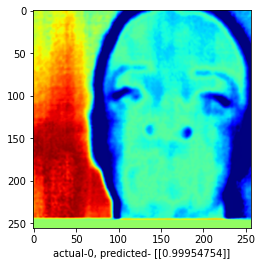

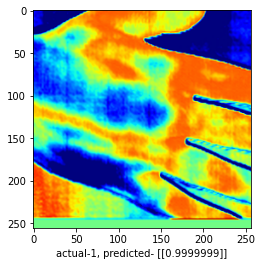

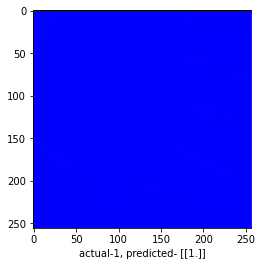

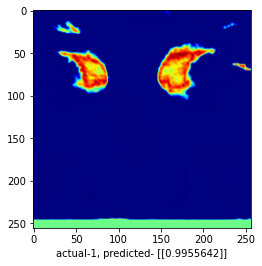

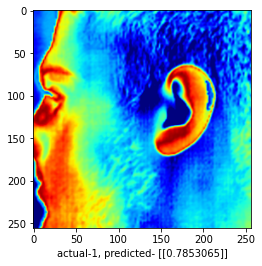

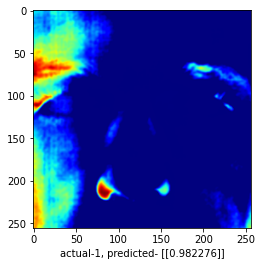

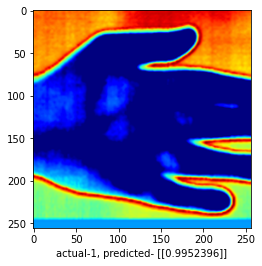

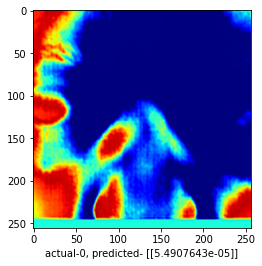

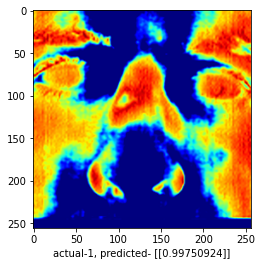

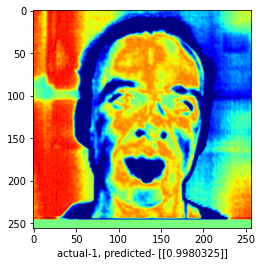

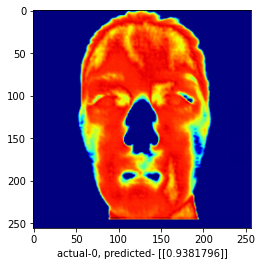

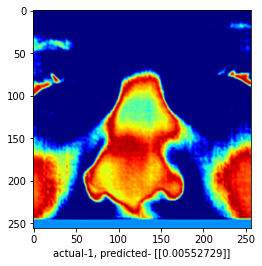

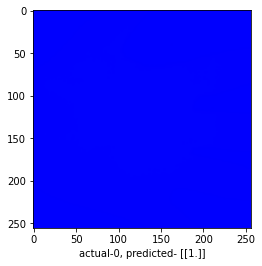

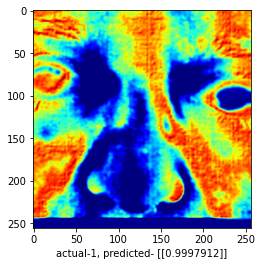

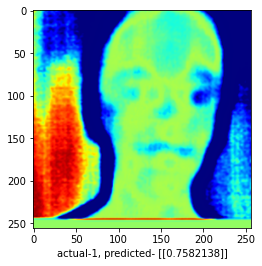

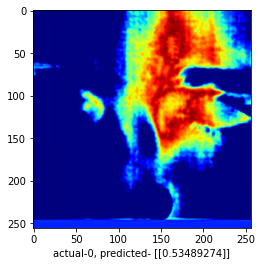

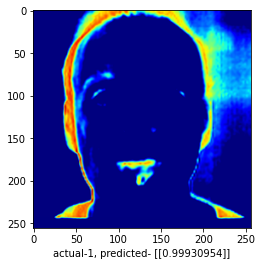

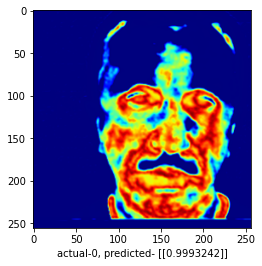

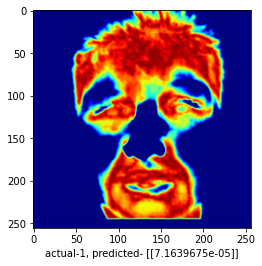

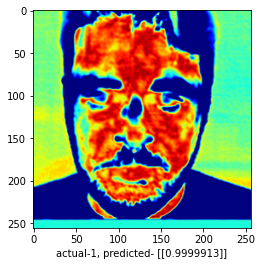

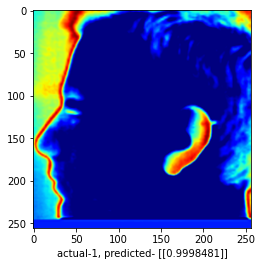

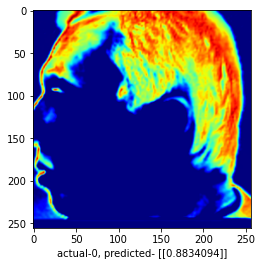

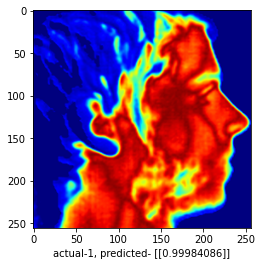

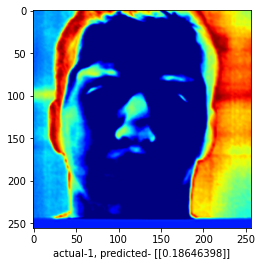

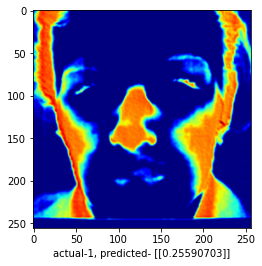

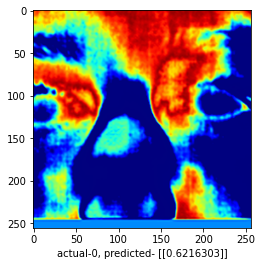

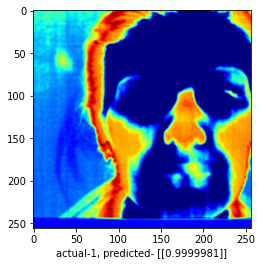

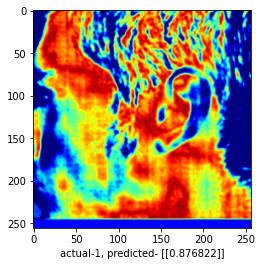

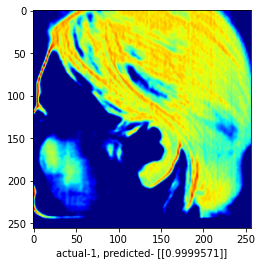

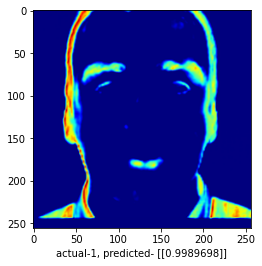

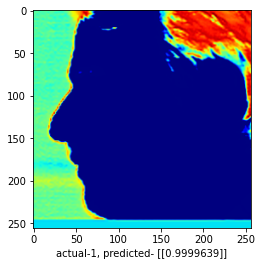

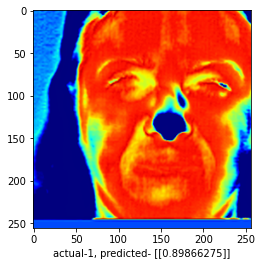

In [ ]:
for i,img in enumerate(x_test):  
  img  = np.expand_dims(img, axis = 0)
  hm = make_gradcam_heatmap(img, base_model, layer_name = None, pred_index=None)
  si = save_and_display_gradcam(img.reshape(256,256,3), hm, save = None, cam_path=None, alpha=0.7)
  plt.imshow(si)
  plt.xlabel(f'actual-{y_test[i]}, predicted- {base_model.predict(img)}')
  plt.show()

In [ ]:
layer_names = []
for layer in model.layers:
  layer_names.append(layer.name)

images_per_row = 16

In [ ]:
layer_names[:100]

In [ ]:
layer_outputs = [layer.output for layer in model.layers] # Extracts the outputs of the top 12 layers
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [ ]:
img_tensor = x_test[0].reshape(1,256,256,3)

In [ ]:
activations = activation_model.predict(img_tensor) # Returns a list of five Numpy arrays: one array per layer activation

In [ ]:
grids = []

In [ ]:
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.imshow(display_grid)
    plt.show()
    #grids.append(display_grid)
    #plt.figure(figsize=(20,10))
    #plt.figure(figsize=(int(scale * display_grid.shape[1]),
    #                    int(scale * display_grid.shape[0])))
    #plt.title(layer_name)
    #plt.grid(False)
    #plt.imshow(display_grid, aspect='auto', cmap='viridis')


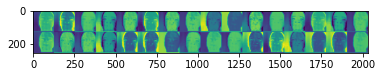

In [ ]:
plt.imshow(grids[6])